In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import matplotlib.pyplot as plt
#from src.dataloader import DataloaderEuropean1D, DataloaderAmerican1D
from src.PINN import PINNforwards
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

In [5]:
def make_training_plot(filename : str, for_validation : bool = False):
    types_of_loss = ["total_loss", "loss_boundary",
                     "loss_pde", "loss_expiry", "loss_lower", "loss_upper"]
    if for_validation:
        X_loss = np.loadtxt("results/validation_" + filename + ".txt")
    else:
        X_loss = np.loadtxt("results/loss_" + filename + ".txt")
    
    df_loss = pd.DataFrame(columns = types_of_loss, data = X_loss)
    df_loss["epoch"] = np.arange(1, len(df_loss) + 1)
    df_melted = df_loss.melt(id_vars = "epoch", value_vars=types_of_loss, var_name='Category', value_name = "Loss")

    y_name = "Validation loss " if for_validation else "Loss"
    fig = px.line(df_melted, x = "epoch", y = "Loss", color = "Category", log_y = True)
    fig.show()

In [ ]:
filename = "multi_1_560"
make_training_plot(filename)


In [ ]:
filename = "multi_1_560"
make_training_plot(filename, True)

In [24]:
def make_heat_map(layers : list[int], nodes : list[int], filename : str):
    data = np.zeros((len(layers), len(nodes)))
    
    for i, layer in enumerate(layers):
        for j, node in enumerate(nodes):
            X_loss = np.loadtxt("results/" + filename + f"_{layer}_{node}" ".txt")
            data[i,j] = np.min(X_loss[:,1])
    
    #np.savetxt("results/"+filename + "_lowest_MSE" ".txt", data)
    df = pd.DataFrame(data, index=layers, columns=nodes)
    formatted_df = df.applymap(lambda x: f'{x:.2e}')

    fig = px.imshow(df, 
                labels=dict(x="Columns", y="Rows", color="Value"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()

In [ ]:
make_heat_map(["1","2","3","4","5","6","7"], ["10","20","40","80","160","320","560"], "loss_multi")

In [ ]:
make_heat_map(["1","2","3","4","5","6","7"], ["10","20","40","80","160","320","560"], "validation_multi")

In [5]:
def make_heat_map_activation(filename : str, activation_functions : list[str], layers : list[str]):
    data = np.loadtxt(filename)

    df = pd.DataFrame(data, index=activation_functions, columns=layers)
    formatted_df = df.applymap(lambda x: f'{x:.2e}')

    fig = px.imshow(df, 
                labels=dict(x="Layers", y="Activation function", color="Value"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()


In [ ]:
make_heat_map_activation("important_results/different_activation.txt", ["ReLU", "LeakyReLU", "Sigmoid", "Tanh"], ["1", "2", "4", "8", "16"])

In [2]:
def make_heat_map_learning_rate(filename : str, learning_rates : list[str], batch_sizes : list[str], format : str):
    data = np.loadtxt(filename)

    df = pd.DataFrame(data, index=learning_rates, columns=batch_sizes)
    formatted_df = df.applymap(format)

    fig = px.imshow(df, 
                labels=dict(x="Batch size", y="Learning rate", color="Batch size"), 
                text_auto=True,  # This automatically adds values in the cells
                aspect="auto")

    fig.update_traces(text=formatted_df.values, texttemplate="%{text}")
    # Show the plot
    fig.show()

In [4]:
make_heat_map_learning_rate("important_results/MSE_lr_1d_european.txt", ["1e-2", "5e-3", "1e-3", "5e-4", "1e-4", "5e-5"], ["100", "1_000", "5_000", "10_000"], lambda x: f'{x:.2e}')

/tmp/ipykernel_3107194/4162884187.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [5]:
make_heat_map_learning_rate("important_results/epoch_lr_1D_european.txt", ["1e-2", "5e-3", "1e-3", "5e-4", "1e-4", "5e-5"], ["100", "1_000", "5_000", "10_000"], lambda x: f'{x:.0f}')

/tmp/ipykernel_3107194/4162884187.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [5]:
def compare_model_with_analytical_1D(model_name, dataloader):
    S_range, t_range = dataloader.S_range, dataloader.time_range

    model = PINN(2, 1, 300, 5).to(DEVICE)
    model.load_state_dict(torch.load(model_name, weights_only=True))

    s = np.linspace(S_range[0], S_range[1], 100)
    t = np.linspace(t_range[0], t_range[1], 100)
    s_grid, t_grid = np.meshgrid(s, t)
    s_flat = s_grid.flatten()
    t_flat = t_grid.flatten()

    # Create a 2D tensor from the flattened arrays
    X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)
    X_test_scaled = dataloader.normalize(X_test)
    # X_test_norm = euro_call_data.normalize(X_test)
    y_analytical_test = dataloader.get_analytical_solution(X_test[:,1],X_test[:,0])
    model.eval()
    with torch.no_grad():
        y_pinn_test = model(X_test_scaled)
    
    err = (y_pinn_test-y_analytical_test.reshape(y_analytical_test.shape[0],-1)).cpu().numpy()
    loss_mse = np.square(err).sum()/(len(err))
    print(f"MSE net: {loss_mse:.3f}")

    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(s_grid, t_grid, y_analytical_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
    ax.set_title("Analytical Soln")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(s_grid, t_grid, y_pinn_test.cpu().numpy().reshape(s_grid.shape), cmap = "viridis")
    ax.set_title("PINN prediction")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    plt.show()
    #plt.savefig(experiment_dir+f"/true_vs_pred_final.jpg")
    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(121, projection='3d')
    err = y_pinn_test.cpu().numpy().reshape(s_grid.shape) - y_analytical_test.cpu().numpy().reshape(s_grid.shape)
    ax.plot_surface(s_grid, t_grid, err, cmap = "viridis")
    ax.plot_surface(s_grid, t_grid, np.zeros(err.shape), color = "grey")
    ax.set_title("Analytical Soln - Predicted")
    ax.set_xlabel("Spot Price")
    ax.set_ylabel("Time to expiry")
    ax.set_zlabel("Call price")
    ax.view_init(elev=20, azim=-120)
    plt.show()


<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:38: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2456898/3441071041.py:31: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")
/tmp/ipykernel_2456898/3441071041.py:38: SyntaxWarning: invalid escape sequence '\i'
  ax.set_ylabel(f"current time (t), $t \in {[t_range]}$")


In [ ]:
dataloader = DataloaderEuropean1D([0,1], [0, 100], 20, 0.03, 0.25, DEVICE)
compare_model_with_analytical_1D("models/epoch_9985_test_analytical.pth", dataloader)

MSE net: nan


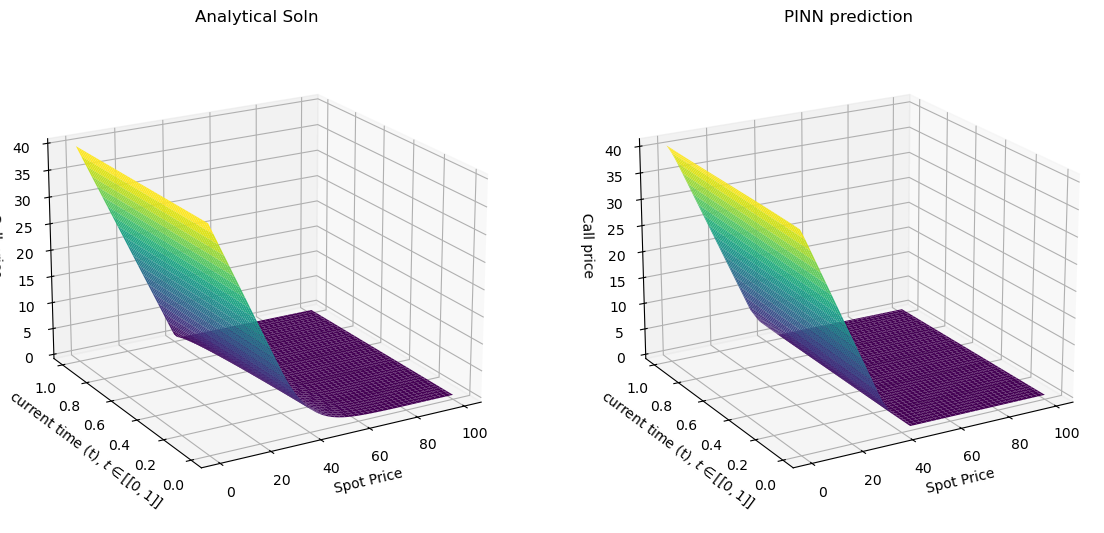

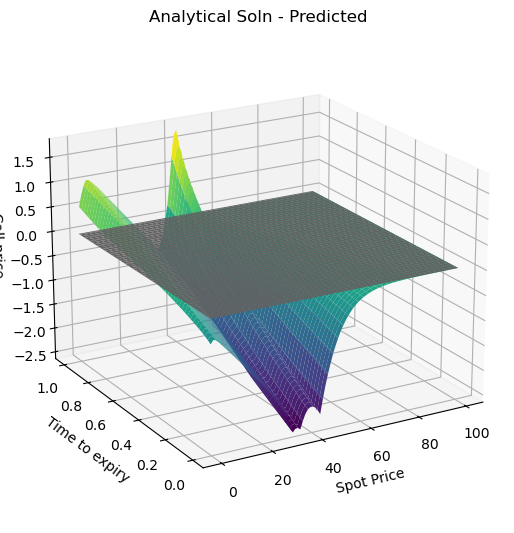

In [6]:
dataloader = DataloaderAmerican1D([0, 1], [0, 100], 40, 0.04, 0.25, DEVICE)
compare_model_with_analytical_1D("models/epoch_9941_america_test.pth", dataloader)

In [23]:
#X_analytical = np.loadtxt("results/analytical_test.txt")
#X_validation_data = np.loadtxt("results/validation_data.txt")

In [8]:
#df_analytical = pd.DataFrame(X_analytical, columns = ["value"])
#df_validation_data = pd.DataFrame(X_validation_data, columns = ["t", "S"])

In [38]:
def make_std_plot(filename):
    loss = np.loadtxt("results/average_loss_" + filename)
    std_loss = np.loadtxt("results/std_loss_" + filename)

    loss_upper = loss + std_loss
    loss_lower = loss - std_loss
    x_loss = np.arange(1, len(loss) + 1)

    val = np.loadtxt("results/average_validation_" + filename)
    std_val = np.loadtxt("results/std_validation_" + filename)

    val_upper = val + std_val
    val_lower = val - std_val
    x_val = np.arange(1, len(loss) + 1, 30)

    fig = make_subplots(rows=2, cols=1, subplot_titles=("Plot 1", "Plot 2"))

    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss[1000::10], mode='lines+markers', name='Data 1', line=dict(color='red')), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss_upper[1000::10], fill=None, mode='lines', line=dict(color='rgba(255,0,0,0)')), row=1, col=1)
    fig.add_trace(go.Scatter(x=x_loss[1000::10], y=loss_lower[1000::10], fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.2)')), row=1, col=1)

    # Second plot (y2 with shaded error band)
    fig.add_trace(go.Scatter(x=x_val, y=val, mode='lines+markers', name='Data 2', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=x_val, y=val_upper, fill=None, mode='lines', line=dict(color='rgba(0,0,255,0)')), row=2, col=1)
    fig.add_trace(go.Scatter(x=x_val, y=val_lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,0,255,0.2)')), row=2, col=1)

    #fig.update_yaxes(type='log', row=1, col=1)  # Log scale for first plot
    #fig.update_yaxes(type='log', row=2, col=1)  # Log scale for second plot
    # Update layout
    fig.update_layout(height=600, width=800, title_text="2x1 Plot with Standard Deviation")

    # Show the plot
    fig.show()

In [39]:
for cur in ["lr_1", "lr_2", "lr_3", "lr_4"]:
    make_std_plot(cur)

In [5]:
X = np.load("results/average_lambdas_test.npy")

In [10]:
X

array([[ 1.        ,  1.44044288,  7.19964327, ..., 33.38380471,
        34.62077206, 34.37576594],
       [ 1.        ,  9.56820994,  9.81053147, ...,  1.69212945,
         1.68750047,  1.68158299],
       [ 1.        ,  1.69134719,  4.41982526, ..., 64.92406584,
        63.69172747, 63.94265108],
       [ 0.        ,  0.12929644,  2.01651945, ...,  3.81676308,
         3.8689009 ,  3.79329707],
       [ 0.        ,  0.17783317,  1.85599277, ...,  1.00554172,
         1.14142318,  1.13889948],
       [ 0.        ,  0.09440842,  2.15200292, ...,  4.04446565,
         4.23625457,  4.13388314]])

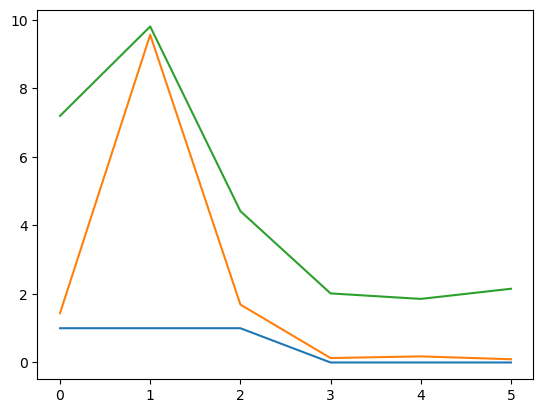

In [14]:
plt.plot(X[:, 0])
plt.plot(X[:, 1])
plt.plot(X[:, 2])
#plt.plot(X[0, ::1000] + X[1, ::1000])
#plt.yscale("log")

In [3]:
np.min(X[0, ::1000] - X[1, ::1000])

NameError: name 'np' is not defined

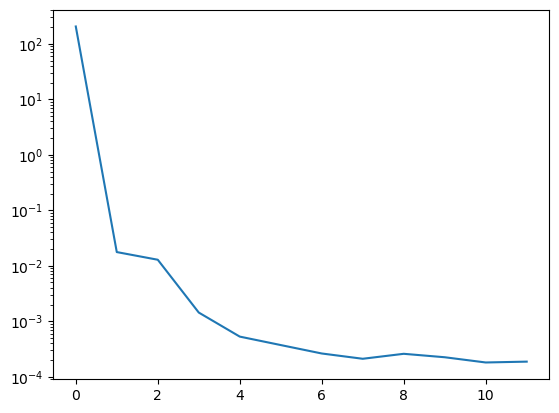

In [9]:
plt.plot(X[1,::1000])
plt.yscale("log")

In [3]:
X = np.load("important_results_backwards/sigmas_learning_test.npy")

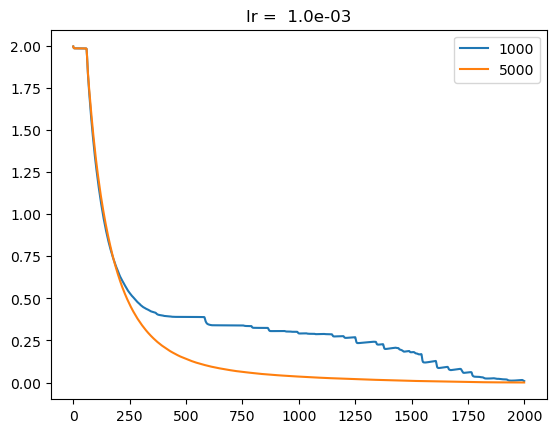

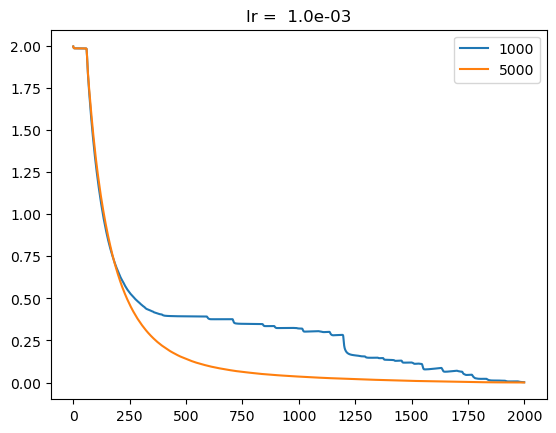

In [4]:
scale = [1_000, 5_000]
lr = [1e-3, 5e-4]
for i in range(0, X.shape[0], 2):
    for j in range(2):
        plt.plot(X[i + j, :], label = f"{scale[j]}")
    plt.title(f"lr = {lr[i // 5] : .1e}")
    plt.legend()
    plt.show()

/tmp/ipykernel_2225404/2425453235.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/greeks.pth"))


In [52]:
n = 50
S_range = [0,200]
t_range = [0,1]
s = np.linspace(*S_range, n)
t = np.linspace(*t_range, n)
S, T = np.meshgrid(s, t)

In [53]:

X = torch.tensor(np.column_stack((T.flatten(), S.flatten())), dtype=torch.float)
min_values = torch.tensor(
            [t_range[0], S_range[0]]).to(DEVICE)
max_values = torch.tensor(
    [t_range[1], S_range[1]]).to(DEVICE)

X_scaled = (X - min_values) / (max_values - min_values)
#Z = model.forward()

In [54]:
from torch.distributions import Normal
def get_analytical_solution(S, t, t_range, sigma, r, K):
        T = t_range[-1]
        t2m = T-t  # Time to maturity
        d1 = (torch.log(S / K) + (r + 0.5 * sigma**2)
              * t2m) / (sigma * torch.sqrt(t2m))

        d2 = d1 - sigma * torch.sqrt(t2m)

        # Normal cumulative distribution function (CDF)
        standard_normal = Normal(0, 1)

        Nd1 = standard_normal.cdf(d1)
        Nd2 = standard_normal.cdf(d2)

        # Calculate the option price
        F = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
        return F

In [55]:
model = PINNforwards(2,1,256, 4)
model.load_state_dict(torch.load("models/greeks.pth", weights_only=True))
model = model.to(DEVICE)

Z_model = model(X_scaled).to("cpu").detach().numpy().reshape((n,n))
Z_analytical = get_analytical_solution(X[:,1], X[:,0], t_range, 0.5, 0.04, 40).to("cpu").detach().numpy().reshape((n,n))

In [74]:
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],  # Specify 3D plots
    subplot_titles=("Predicted", "Analytical", "Predicted subtracted Analytical"),
    #horizontal_spacing=0.5
)

# Add the first 3D surface plot
fig.add_trace(
    go.Surface(z=Z_model, x=S, y=T, colorscale='Cividis', showscale = True, colorbar=dict(title="Option price", x= 0.65)), 
    row=1, col=1
)

# Add the second 3D surface plot
fig.add_trace(
    go.Surface(z=Z_analytical, x=S, y=T, showscale = False,colorscale='Cividis'),
    row=1, col=2
)

fig.add_trace(
    go.Surface(z=Z_model - Z_analytical, x=S, y=T, colorscale='Viridis', showscale=True, colorbar=dict(title="Difference", x = 1.0)),
    row=1, col=3
)

fig.update_layout(
    scene=dict(
        xaxis_title="Stock price",
        yaxis_title="Time",
        zaxis_title="Option price",
        camera=dict(eye=dict(x=-1, y=2, z=2)),  # Adjust view for both plots
        zaxis=dict(
            tickvals=[np.max(Z_analytical) // 4, np.max(Z_analytical) // 8*5,  np.round(np.max(Z_analytical))],  # Specify the ticks to display
        ),
        xaxis = dict(
            tickvals=[np.min(S), np.max(S) // 2,  np.round(np.max(S))],  # Specify the ticks to display
        ),
    ),
    scene2=dict(  # Layout for the second plot
        xaxis_title="Stock price",
        yaxis_title="Time",
        zaxis_title="Option price",
        camera=dict(eye=dict(x=-1, y=2, z=2)),  # Adjust view for both plots
        zaxis=dict(
            tickvals=[np.max(Z_analytical) // 4, np.max(Z_analytical) // 8*5,  np.round(np.max(Z_analytical))],  # Specify the ticks to display
        ),
        xaxis = dict(
            tickvals=[np.min(S), np.max(S) // 2,  np.round(np.max(S))],  # Specify the ticks to display
        ),
    ),
    scene3=dict(  # Layout for the second plot
        xaxis_title="Stock price",
        yaxis_title="Time",
        zaxis_title="Option price",
        camera=dict(eye=dict(x=-1, y=2, z=2)),  # Adjust view for both plots
        xaxis = dict(
            tickvals=[np.min(S), np.max(S) // 2,  np.round(np.max(S))],  # Specify the ticks to display
        ),
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    font=dict(size=17),
    
)
fig.update_annotations(font_size=30)

# Show the plot
fig.write_image("plots/one_dim_european.pdf", width=2200, height=800, scale=1)
fig.show()

In [46]:
n = 1_000
S_range = [0,200]
t_range = [0,1]
S = np.linspace(*S_range, n)
T = np.full(n, 0.5)

X = torch.tensor(np.column_stack((T, S)), dtype=torch.float, requires_grad=True)
min_values = torch.tensor(
            [t_range[0], S_range[0]]).to(DEVICE)
max_values = torch.tensor(
    [t_range[1], S_range[1]]).to(DEVICE)

X_scaled = (X - min_values) / (max_values - min_values)


In [47]:
model = PINNforwards(2,1,256, 4)
model.load_state_dict(torch.load("models/greeks.pth", weights_only=True))
model = model.to(DEVICE)

delta, gamma, theta, nu, rho = model.estimate_greeks_call(X_scaled, X, 0.5, t_range[1])

In [48]:
delta = delta.to("cpu").detach().numpy().flatten()
gamma = gamma.to("cpu").detach().numpy().flatten()
theta = theta.to("cpu").detach().numpy().flatten()
nu = nu.to("cpu").detach().numpy().flatten()
rho = rho.to("cpu").detach().numpy().flatten()

In [51]:
fig = make_subplots(
    rows=2, cols=3,
    specs=[
        [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}],  # Row 1: 3 columns
        [{'type': 'xy'}, {'type': 'xy'}, None]            # Row 2: 2 columns
    ],
    subplot_titles=(r"$\Delta$", r"$\Gamma$", r"$\Theta$", r"$\nu$", r"$\rho$"),
    horizontal_spacing=0.1,  # Adjust horizontal spacing
    vertical_spacing=0.2     # Adjust vertical spacing
)

# Add line plots to the first row
fig.add_trace(go.Scatter(x=S, y=delta, mode='lines', name="Sine", line=dict(width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=S, y=gamma, mode='lines', name="Cosine", line=dict(width=2)), row=1, col=2)
fig.add_trace(go.Scatter(x=S, y=theta, mode='lines', name="Tangent", line=dict(width=2)), row=1, col=3)

# Add line plots to the second row
fig.add_trace(go.Scatter(x=S, y=nu, mode='lines', name="Exponential", line=dict(width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=S, y=rho, mode='lines', name="Quadratic", line=dict(width=2)), row=2, col=2)

# Update layout
fig.update_layout(
    title="Different Greeks at t = 0.5",
    height=800,  # Adjust height to fit all subplots
    width=1000,  # Adjust width for better aspect ratio
    font=dict(size=20),  # Adjust font size
    margin=dict(l=20, r=20, t=50, b=20),  # Tight margins
    showlegend = False
)
fig.update_annotations(font_size=20)
fig.update_xaxes(title_text="Stock Price", row=1, col=1)
fig.update_xaxes(title_text="Stock Price", row=1, col=2)
fig.update_xaxes(title_text="Stock Price", row=1, col=3)
fig.update_xaxes(title_text="Stock Price", row=2, col=1)
fig.update_xaxes(title_text="Stock Price", row=2, col=2)
# Show the plot
fig.write_image("plots/one_dim_european_greeks.pdf", width=2200, height=800, scale=1)
fig.show()

In [9]:
X_lambda = np.load("results/average_loss_with_lambda.npy")
X = np.load("results/average_loss_no_lambda.npy")

X.shape

(800000, 6)

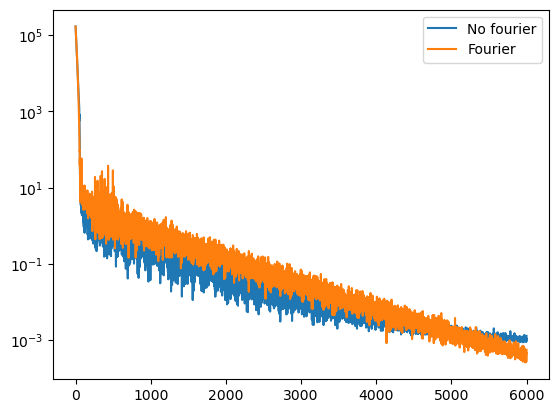

In [10]:
import numpy as np
import matplotlib.pyplot as plt

X_lambda = np.load("results/average_loss_no_fourier.npy")
X = np.load("results/average_loss_with_fourier.npy")
plt.plot(X_lambda[:len(X_lambda) // 2:100, 0], label = "No fourier")
plt.plot(X[:len(X)//2:100, 0], label = "Fourier")

plt.legend()
plt.yscale("log")

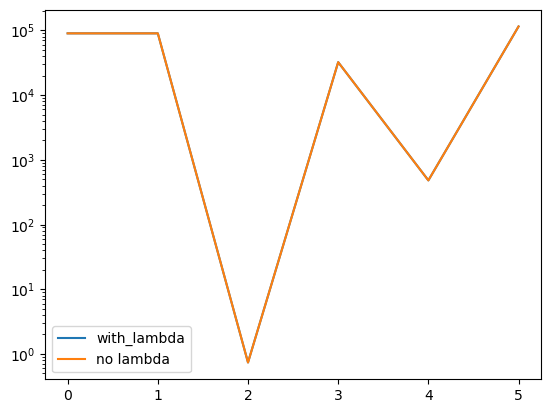

In [ ]:
X_lambda = np.load("results/average_validation_with_lambda.npy")
X = np.load("results/average_validation_no_lambda.npy")
plt.plot(X_lambda[:, 1], label = "with_lambda")
plt.plot(X[1], label = "no lambda")

plt.legend()
plt.yscale("log")

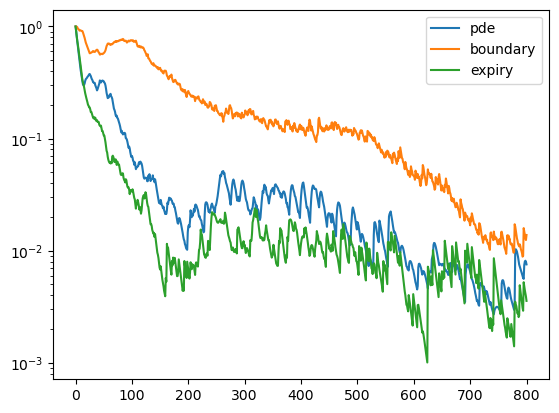

In [36]:
X_lambda = np.load("results/average_lambdas_with_lambda.npy")
X = np.load("results/average_lambdas_no_lambda.npy")
plt.plot(X_lambda[0], label = "pde")
plt.plot(X_lambda[1], label = "boundary")
plt.plot(X_lambda[2], label = "expiry")
#plt.plot(X_lambda[0] + X_lambda[1] + X_lambda[2], label = "sum")
plt.legend()
plt.yscale("log")